# Datasets Visualization

In [1]:
%load_ext lab_black
# %load_ext nb_black # for jupyter nootebook
%load_ext autoreload
%autoreload 2

In [2]:
import string
from pathlib import Path
from itertools import chain

In [3]:
import numpy as np
import pandas as pd

In [4]:
from tqdm.notebook import tqdm

In [5]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [6]:
import matplotlib
from matplotlib.cm import tab10
import matplotlib.pyplot as plt

plt.style.use("seaborn-notebook")

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

r = matplotlib.patches.Rectangle(
    (0, 0), 1, 1, fill=False, edgecolor="none", visible=False
)

## Preprocessing

In [7]:
ac_frame = pd.read_csv("../data/agatha_christie.csv")

X_ac = ac_frame["text"]
y_ac = ac_frame["book"]

np_frame = pd.read_csv("../data/newspaper_articles.csv")

X_np = np_frame["STORY"]
y_np = np_frame["SECTION"].map(
    {0: "Politics", 1: "Technology", 2: "Entertainment", 3: "Business"}
)


ja_frame = pd.read_csv("../data/jane_austen.csv")

X_ja = ja_frame["x_text"]
y_ja = ja_frame["y_book"]

sh_frame = pd.read_csv("../data/sherlock_holmes.csv")


X_sh = sh_frame["rawtext"]
y_sh = sh_frame["label"].map(
    {
        0: "The Valley of Fear",
        1: "The Memoirs of Sherlock Holmes",
        2: "The Return of Sherlock Holmes",
        3: "Adventures of Sherlock Holmes",
    }
)

names = ["Agatha Christie", "Sherlock Holmes", "Jane Austen", "Newspapers"]
X_datasets = [X_ac, X_sh, X_ja, X_np]
y_datasets = [y_ac, y_sh, y_ja, y_np]

In [8]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
table = str.maketrans("", "", string.punctuation + "——")


def remove_stop_words_and_tokenize(text: str) -> str:
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]

    stripped = [w.translate(table) for w in tokens]

    words = [word for word in stripped if word.isalpha()]

    words = [w for w in words if not w in stop_words]

    words = [stemmer.stem(w) for w in words]

    return " ".join(words)

In [9]:
X_prep = []

for name, X in tqdm(zip(names, X_datasets), total=4):
    X_prep.append(
        [remove_stop_words_and_tokenize(x) for x in tqdm(X.values, desc=name)]
    )

  0%|          | 0/4 [00:00<?, ?it/s]

Agatha Christie:   0%|          | 0/266 [00:00<?, ?it/s]

Sherlock Holmes:   0%|          | 0/522 [00:00<?, ?it/s]

Jane Austen:   0%|          | 0/1313 [00:00<?, ?it/s]

Newspapers:   0%|          | 0/7628 [00:00<?, ?it/s]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
tfidfs = []
X_tfidf = []

for name, X in tqdm(zip(names, X_prep), total=4):
    tfidf = TfidfVectorizer(max_features=20_000)

    X_tfidf.append(tfidf.fit_transform(X))

    tfidfs.append(tfidf)

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
for name, X in zip(names, X_tfidf):
    print(name, X.shape)

Agatha Christie (266, 7502)
Sherlock Holmes (522, 6808)
Jane Austen (1313, 7618)
Newspapers (7628, 20000)


## Datasets Visualization

In [13]:
from umap import UMAP

/home/kurak/PA164-ML-and-NLP-Task-2/venv/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [14]:
names

['Agatha Christie', 'Sherlock Holmes', 'Jane Austen', 'Newspapers']

In [15]:
file_names = ["agatha_christie", "sherlock_holmes", "jane_austen", "newspaper_articles"]
embeddings = ["tfidf", "average_fasttext", "avg_glove", "distiluse", "roberta"]

In [18]:
X_emb_umap = []

In [19]:
for embedding in embeddings:
    X_umap = []

    if embedding == "tfidf":
        umap = UMAP(random_state=42, min_dist=0.3, metric="hellinger")
        for X in tqdm(X_tfidf, desc=embedding):
            X_umap.append(umap.fit_transform(X))
    else:
        umap = UMAP(random_state=42, min_dist=0.3, metric="cosine")
        for file_name in tqdm(file_names, desc=embedding):
            X_umap.append(
                umap.fit_transform(
                    pd.read_csv(f"../data/{file_name}-{embedding}.csv", index_col=0)
                )
            )

    X_emb_umap.append(X_umap)

tfidf:   0%|          | 0/4 [00:00<?, ?it/s]

average_fasttext:   0%|          | 0/4 [00:00<?, ?it/s]

avg_glove:   0%|          | 0/4 [00:00<?, ?it/s]

distiluse:   0%|          | 0/4 [00:00<?, ?it/s]

roberta:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

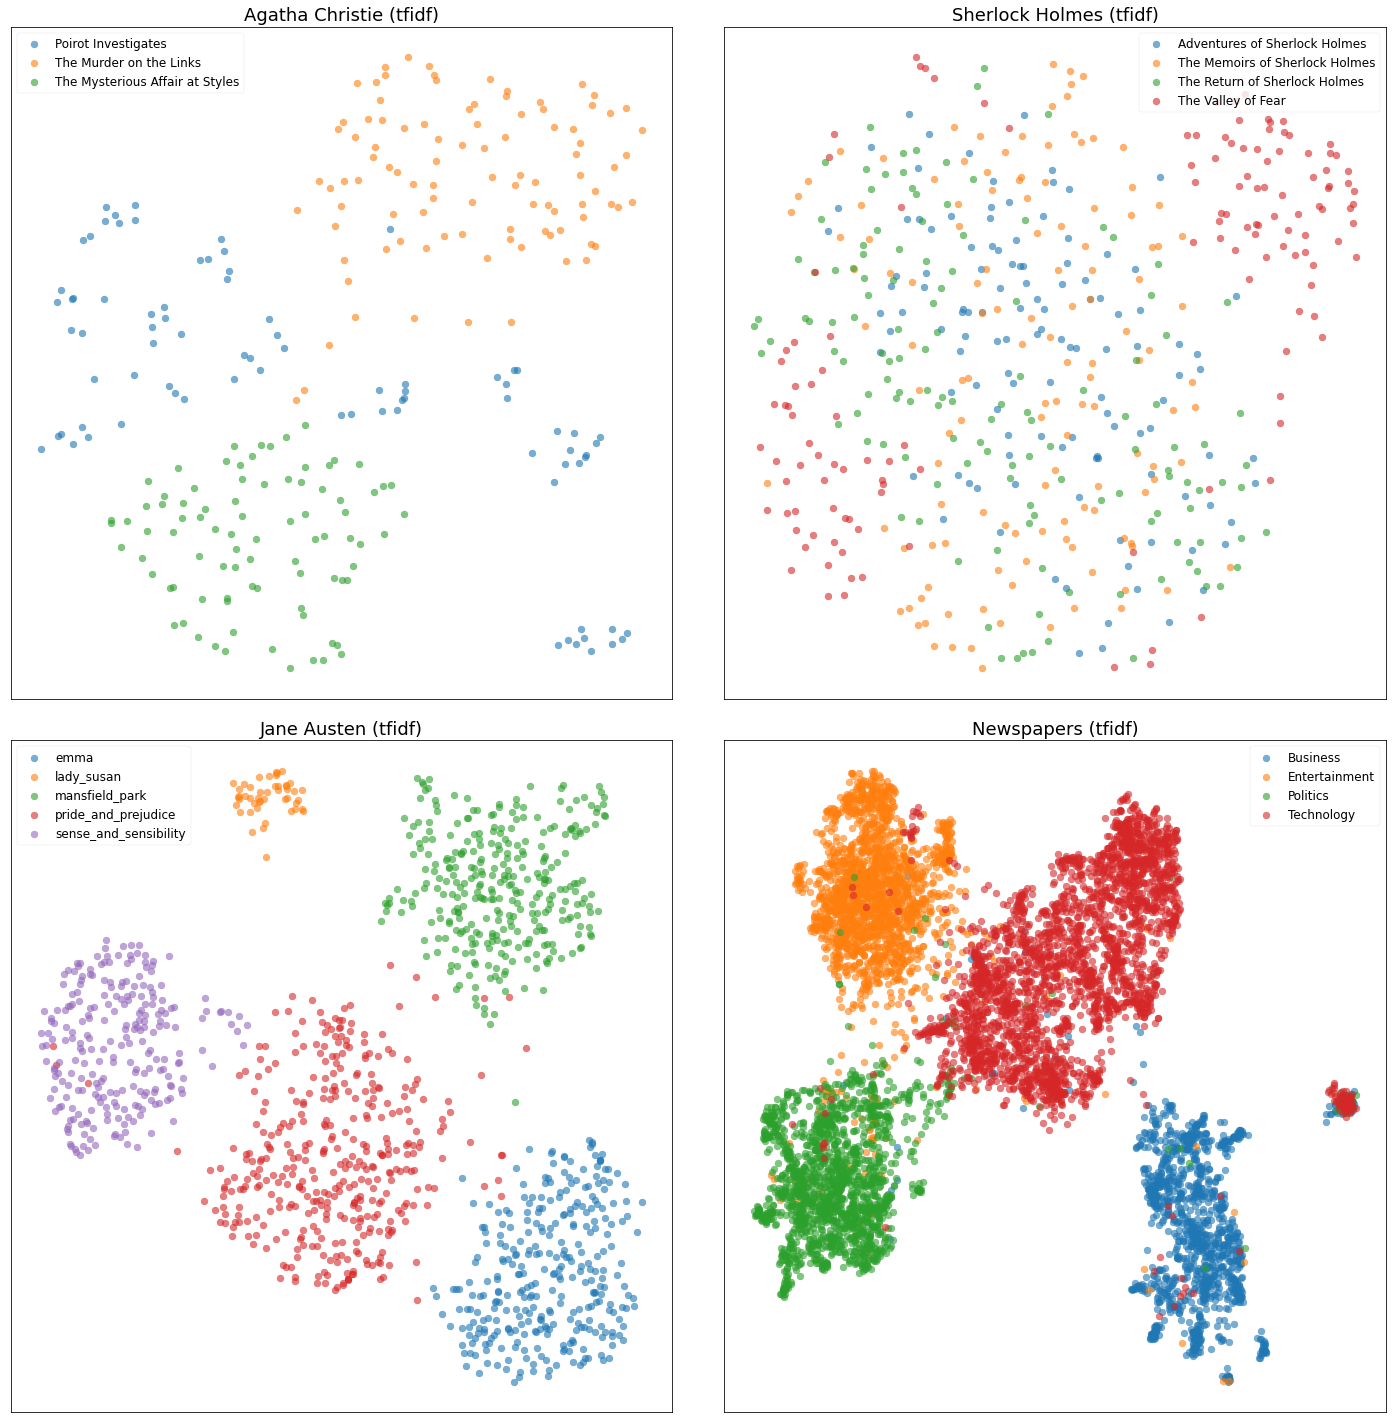

  0%|          | 0/4 [00:00<?, ?it/s]

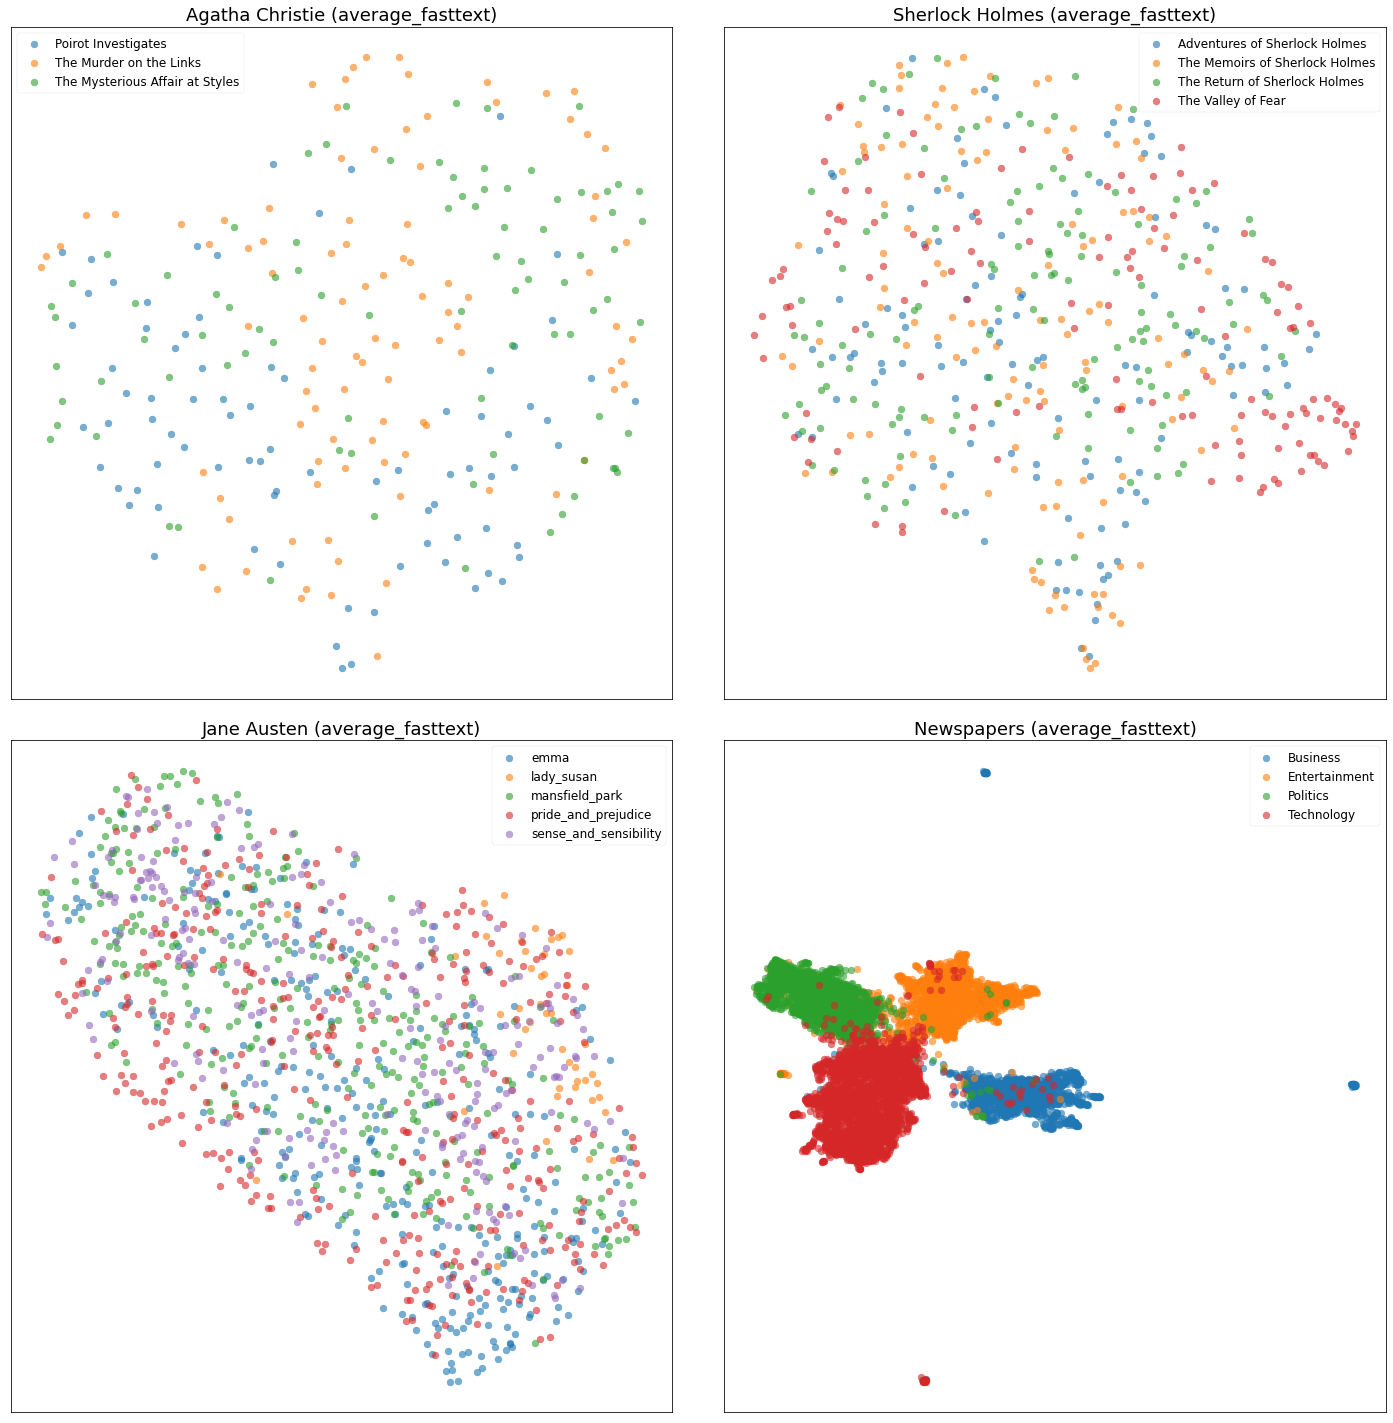

  0%|          | 0/4 [00:00<?, ?it/s]

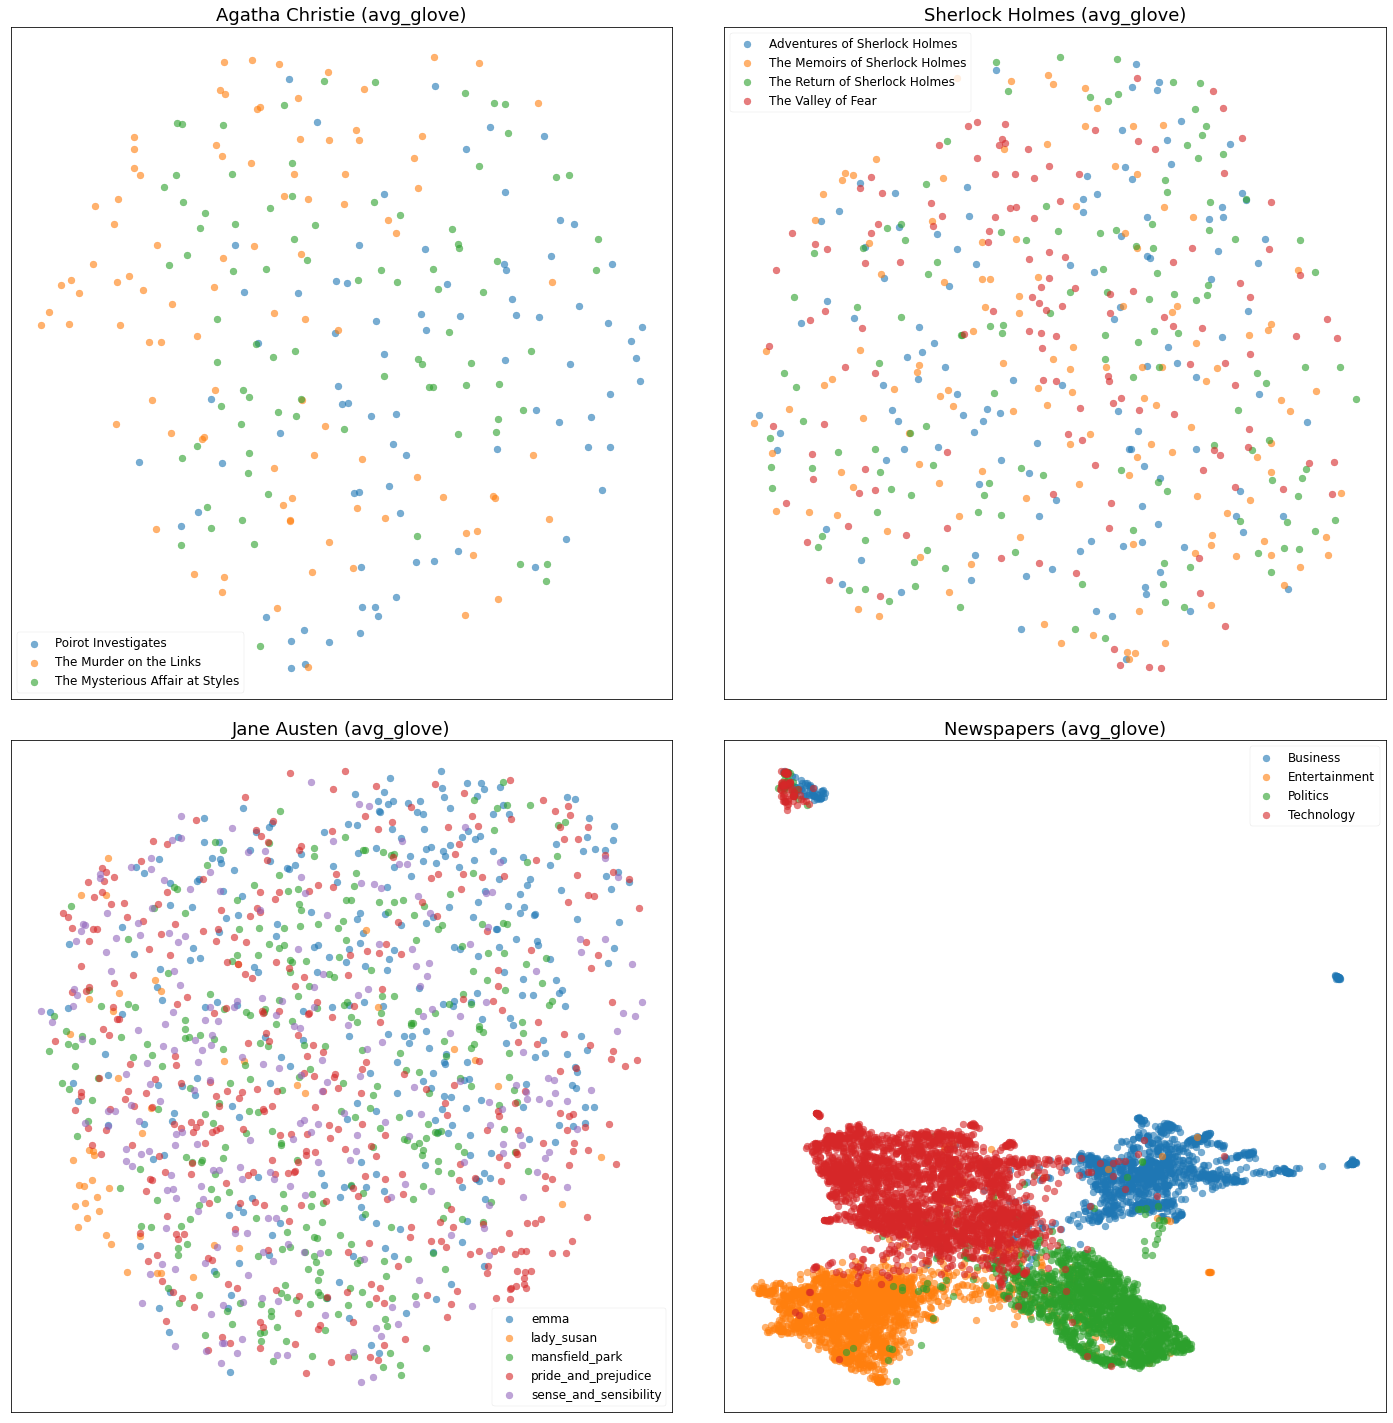

  0%|          | 0/4 [00:00<?, ?it/s]

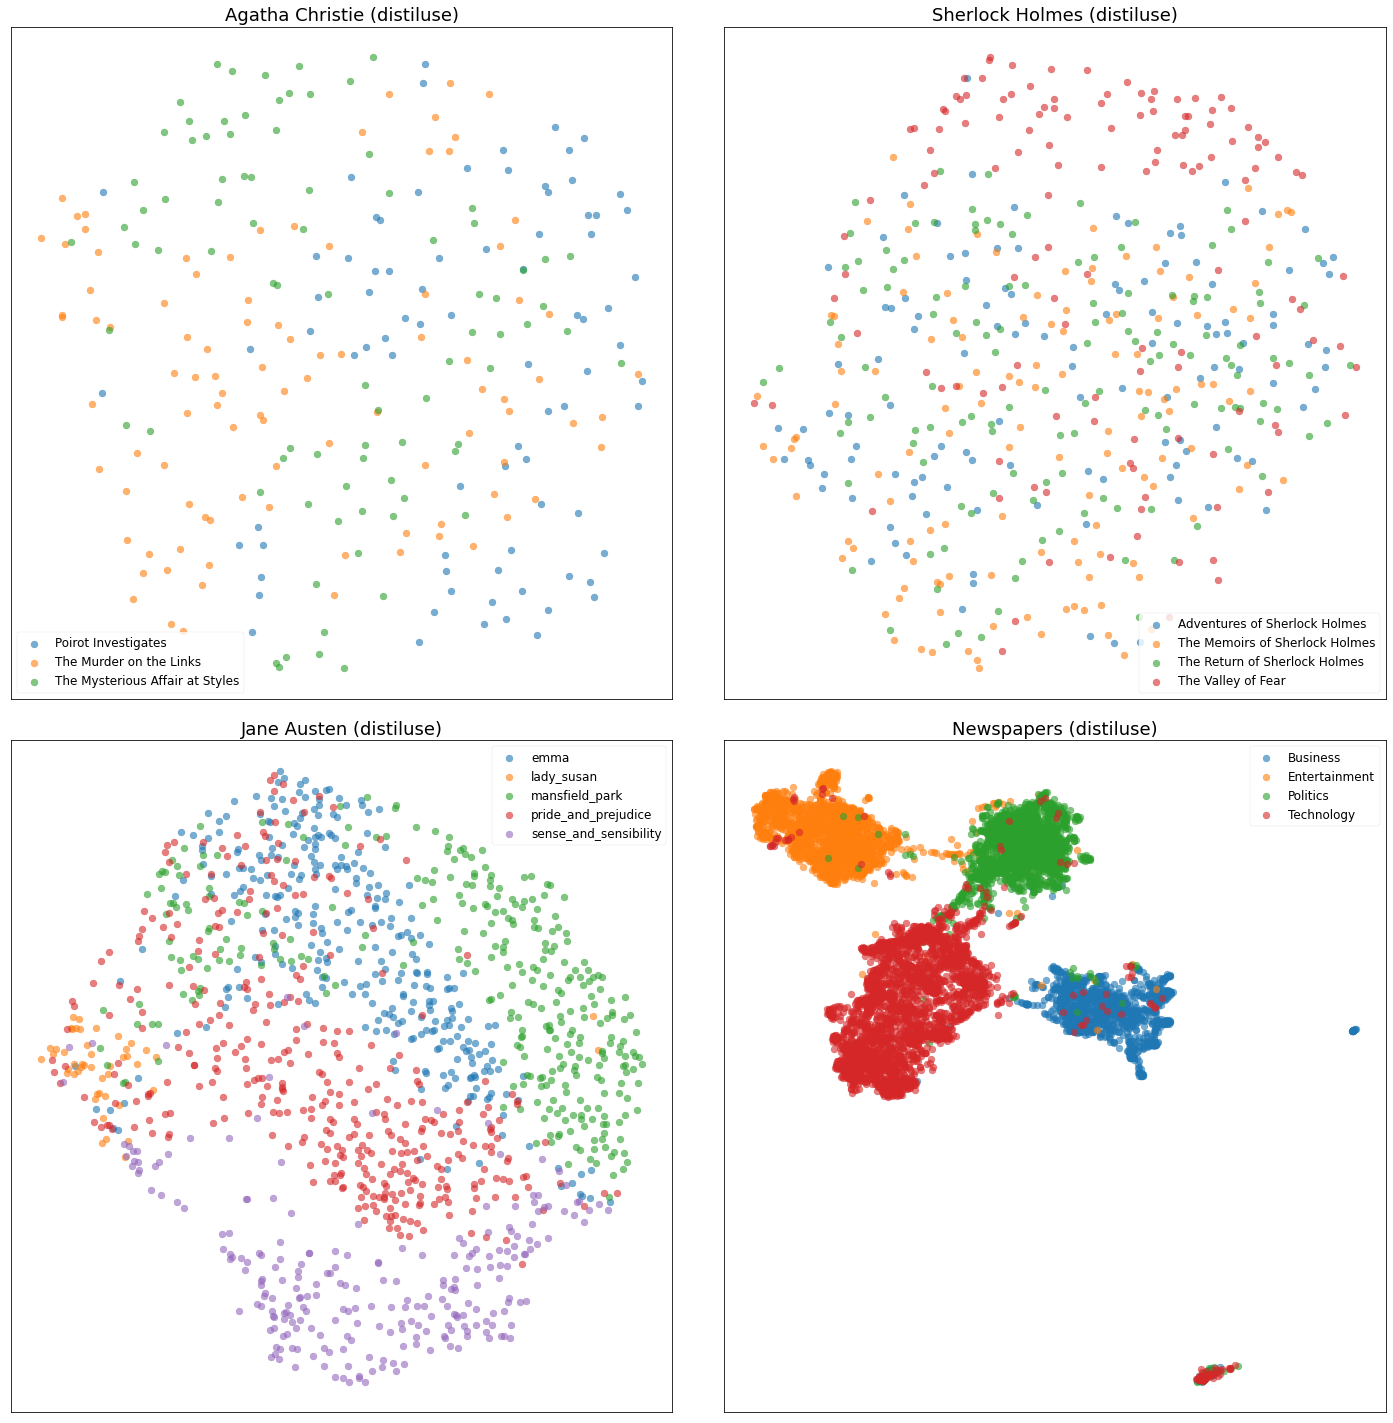

  0%|          | 0/4 [00:00<?, ?it/s]

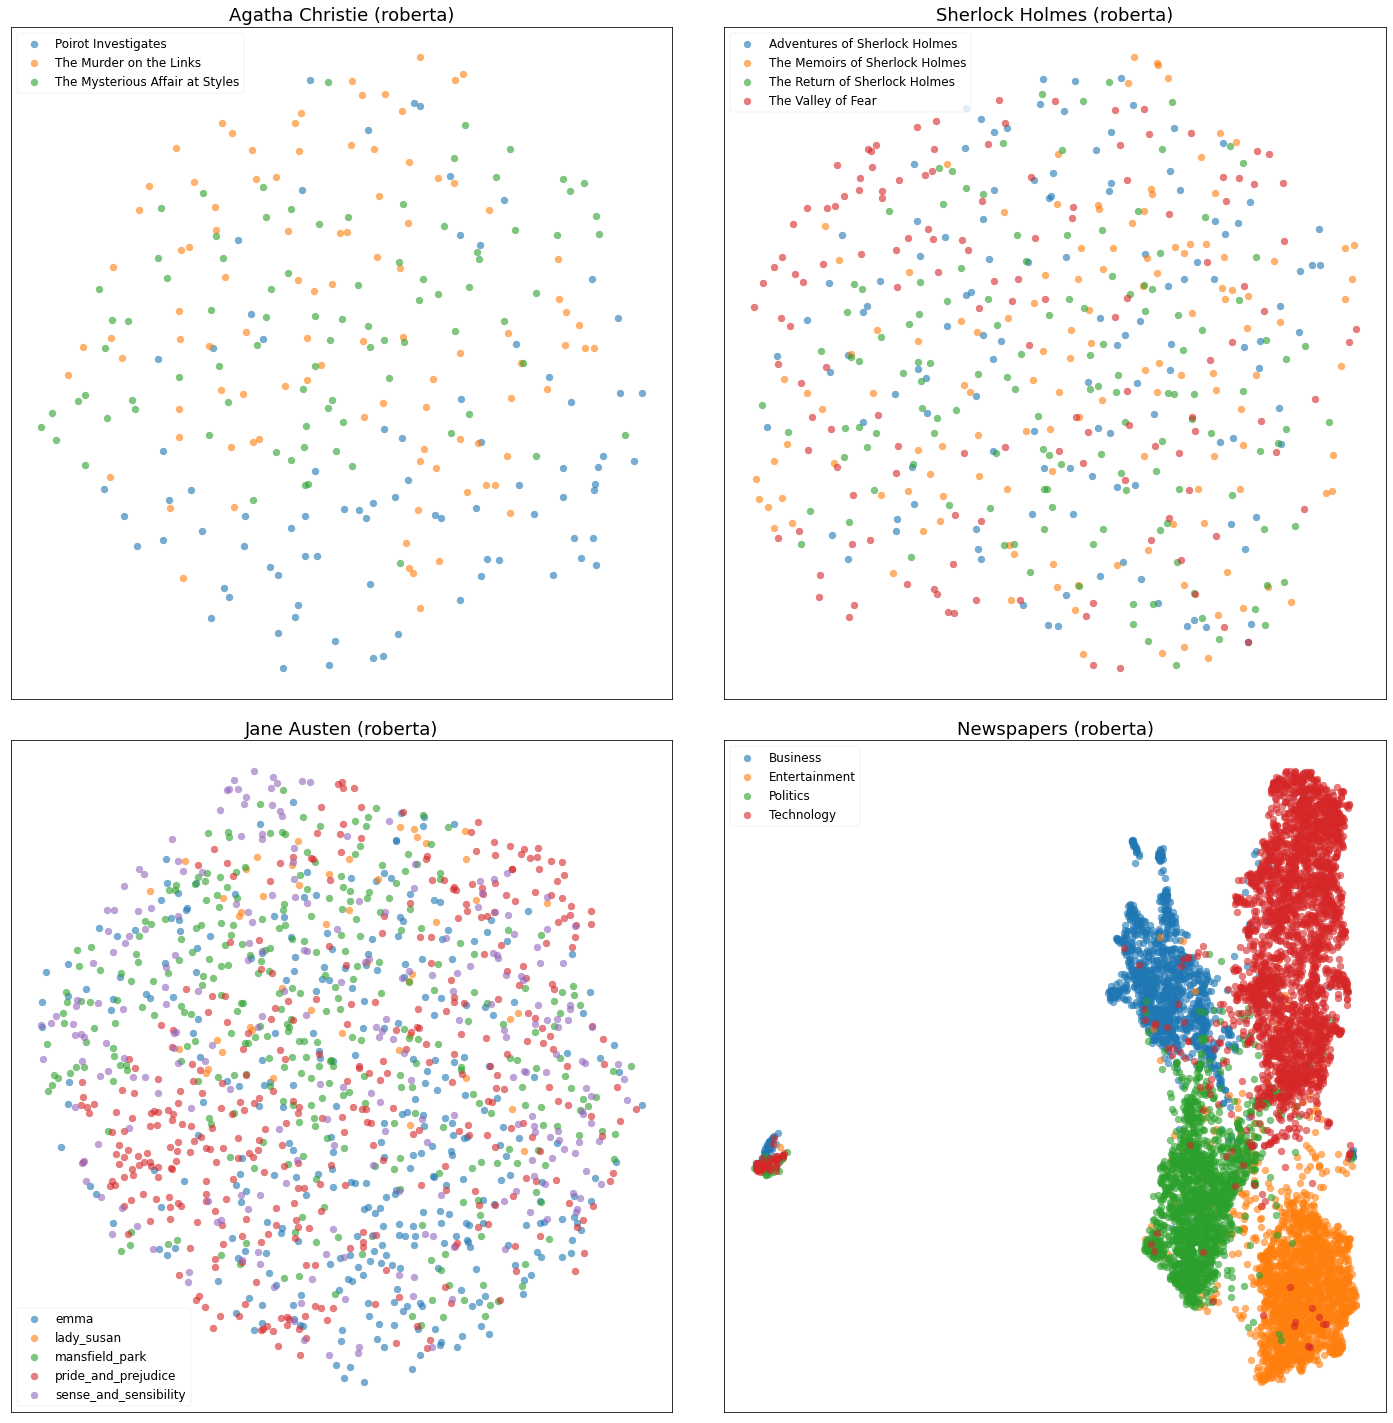

In [20]:
for embedding, X_umap in zip(embeddings, X_emb_umap):

    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    plt.tight_layout()

    for name, X, y, ax in tqdm(zip(names, X_umap, y_datasets, chain(*axs)), total=4):

        ax.set_title(f"{name} ({embedding})")
        for color, label in zip(tab10.colors, np.unique(y)):
            ax.scatter(*X[y == label].T, color=color, alpha=0.6, label=label)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend()

    plt.savefig(f"../imgs/{embedding}-full.png", transparent=False)
    plt.show()